In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
from scipy.stats import spearmanr, kstest, t as tdist, jarque_bera, norm, skew, laplace
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
import datetime as dt
import yfinance as yfin
yfin.pdr_override()
import pymc3

sns.set_theme()

/home/tharindu/anaconda3/envs/sp500model/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Let's import the SPX dataset from yahoo finance and take a look at the data:

In [2]:
df = pdr.get_data_yahoo("^GSPC", start='1920-09-10')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


Plot how the close prices look:

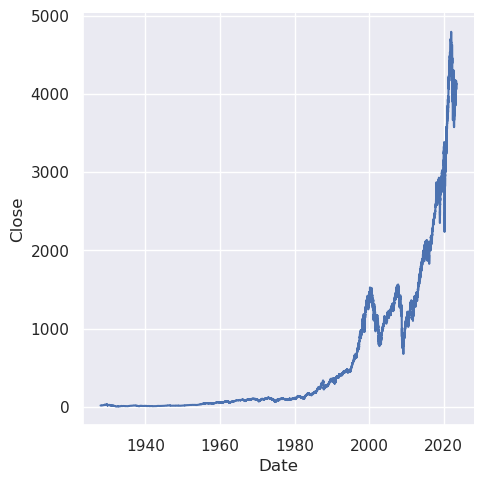

In [15]:
sns.relplot(
    data=df, kind="line",
    x="Date", y="Close"
)

Extract the close data for a time period for analysis

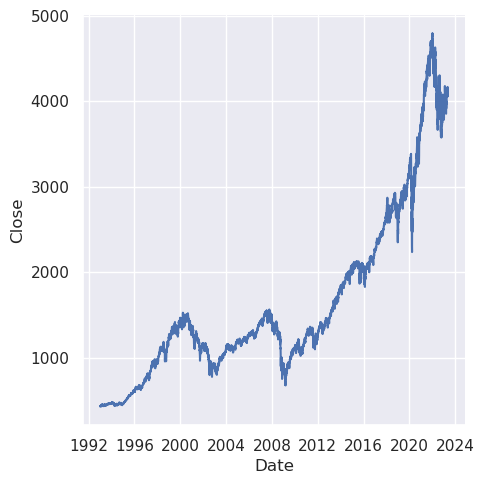

In [39]:
start_date = '1993-01-01';
tclose = df[start_date:].Close
sns.relplot(kind='line', x=tclose.index, y=tclose)

Plot the distribution of the data

/tmp/ipykernel_2731/243025280.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tclose)


<Axes: xlabel='Close', ylabel='Density'>

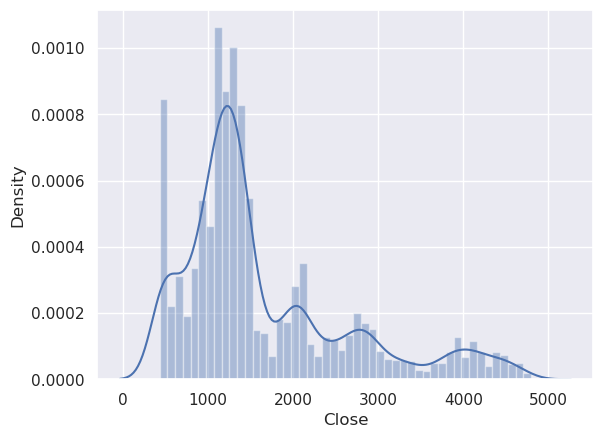

In [45]:
sns.distplot(tclose)

Definitely not a nice stationary time series. We could get rid of some of the non-stationary properties by doing a differencing operation. But this requires a nice evenly-spaced time series. Let's try to fill in some of the missing values. We start by filling in the missing dates and then fill the corresponding nan values by doing a forward fill.

In [41]:
tclose = tclose.asfreq('D')
tclose = tclose.fillna(method='ffill')
tclose.head(10)

Date
1993-01-04    435.380005
1993-01-05    434.339996
1993-01-06    434.519989
1993-01-07    430.730011
1993-01-08    429.049988
1993-01-09    429.049988
1993-01-10    429.049988
1993-01-11    430.950012
1993-01-12    431.040009
1993-01-13    433.029999
Freq: D, Name: Close, dtype: float64

As we can see, the missing dates got forward filled. We choose foward filling since it's both reasonable(market stops at the price it last displayed) and causal(we don't need future information to perform the imputation).

Next we will take the log difference to calculate the log returns of the time series.

In [53]:
tclose_lr = np.log(tclose).diff().shift(-1).dropna()
tclose_lr.head()

Date
1993-01-04   -0.002392
1993-01-05    0.000414
1993-01-06   -0.008760
1993-01-07   -0.003908
1993-01-08    0.000000
Freq: D, Name: Close, dtype: float64

Let's take a look at the data distribution

/tmp/ipykernel_2731/3152022900.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tclose_lr)


<Axes: xlabel='Close', ylabel='Density'>

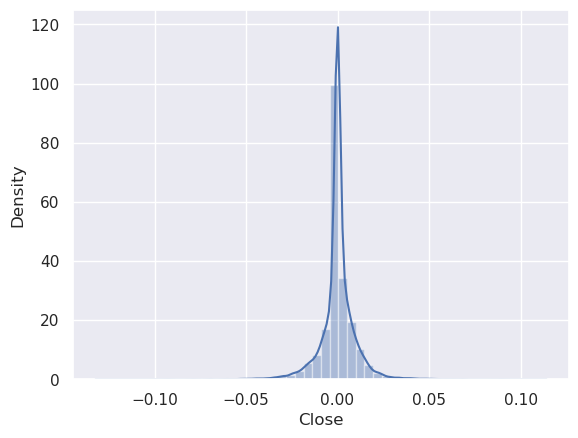

In [54]:
sns.distplot(tclose_lr)

Looks like a nice peaked Laplacian distribution. First let's see how the correlation structure looks.

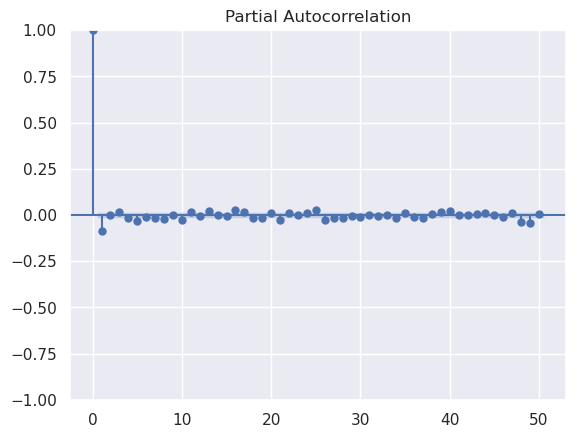

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(tclose_lr, lags=50, title = 'Partial Autocorrelation', method='ywm');

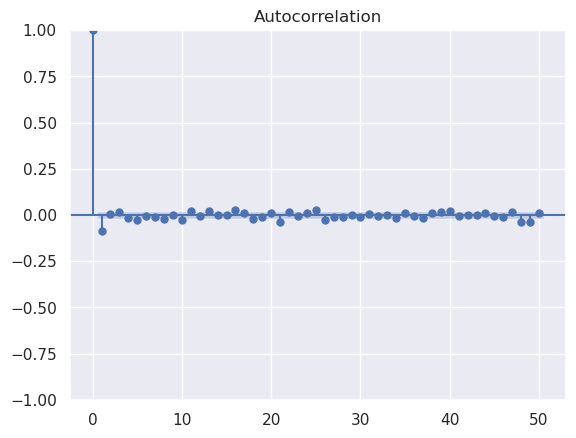

In [60]:
plot_acf(tclose_lr, lags=50, title = 'Autocorrelation');

A bunch of autocorrelations are above the confidence limit and hence there is serious lagged correlations going on. Can we assess the stationarity of the series by looking at the augmented Dickey-Fulle test?

In [61]:
from statsmodels.tsa.stattools import adfuller
adfuller(tclose_lr.values)[1]

0.0

The p-values is pretty much zero and hence the time-series is trend-stationary. How about the variance. Let's take a look at the autocorrelations of the absolute series to see if there is evidence of heretoskedasticity.

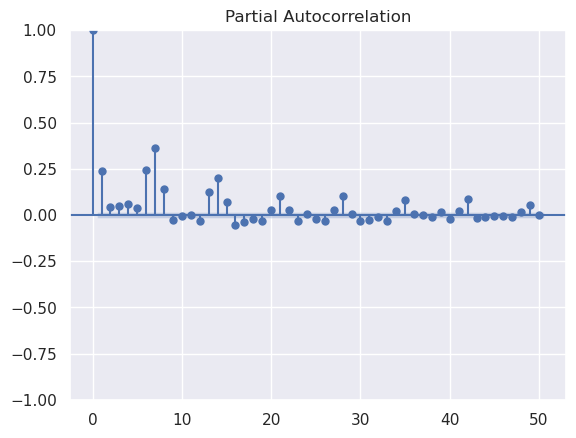

In [64]:
plot_pacf(abs(tclose_lr), lags=50, title = 'Partial Autocorrelation', method='ywm');

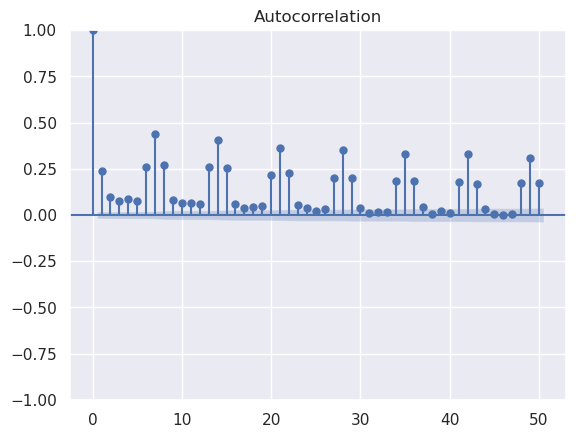

In [65]:
plot_acf(abs(tclose_lr), lags=50, title = 'Autocorrelation');

Yup. Lots and lots of heteroskedasticity.

This means if we use a classical time series model,  we will have to use one that has heteroskedasticity built it. GARCH class of models are probably best in this aspect. But before we head to the time series modelling part, let's try to understand the distribution of the data. This will come in handy in the modelling section.

Let's see if the data fits a normal distribution. For validation purposes, let's do this test for chunks of the time series extending from the start to various end points.

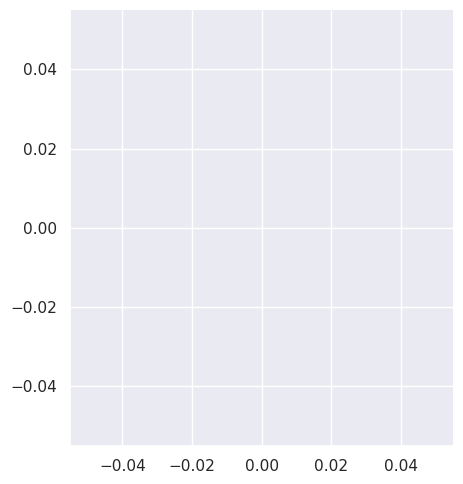

In [75]:
dlength = len(tclose_lr)
jb=[]
for end in range(dlength//2,dlength, 500):
    jb.append(jarque_bera(tclose_lr[:end]).pvalue)
sns.relplot(y=jb)


The plot is empty because the values are all zero. This means the distribution is definitely not normal. Let's give the t distribtion a chance.

0.2953215272816305 -3.935211871215756e-21 2.656271924766011e-20


Text(0.5, 1.0, 'T-distribution fit')

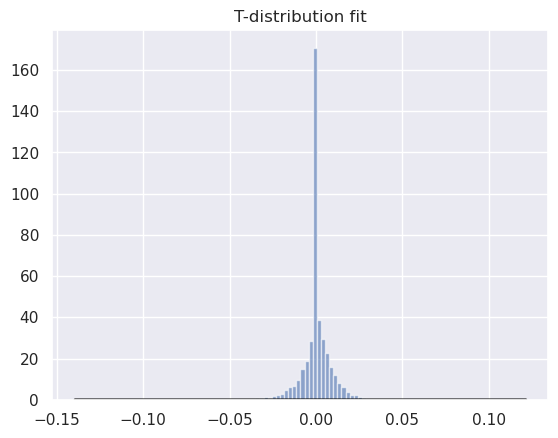

In [89]:
def fit_t(data):
    df, mu, std = tdist.fit(data, loc = data.mean(), scale = data.std())
    plt.hist(data, bins=100, density=True, alpha=0.6, color='b')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = tdist.pdf(x, df, mu, std)  
    plt.plot(x, p, 'k', linewidth=2)
    return df, mu, std
df, mu, std = fit_t(tclose_lr)
print(df, mu, std)
plt.title('T-distribution fit')

In [81]:
kstest(tclose_lr, lambda x: tdist.cdf(x, df = df, loc = mu, scale = std))

KstestResult(statistic=0.3699481629455288, pvalue=0.0)

The KS test and the visual test don't give us much hope. We can try the same with a Laplacian.

0.0 0.005394404263380306


Text(0.5, 1.0, 'Laplace fit')

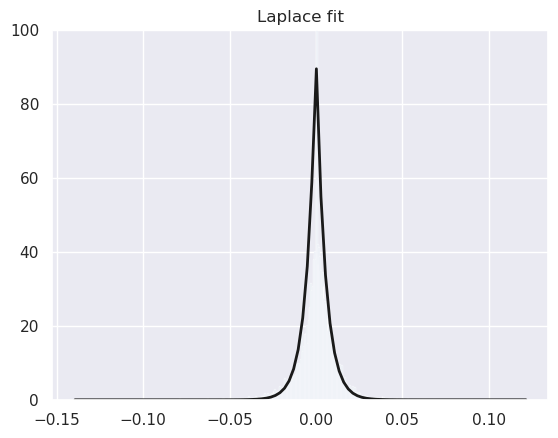

In [97]:
def fit_laplace(data):
    mu, std = laplace.fit(data, loc = data.mean(), scale = data.std())
    print(mu, std)
    plt.hist(data, bins=500, density=True, alpha=0.8, color='b')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = laplace.pdf(x, mu, std)  
    plt.plot(x, p, 'k', linewidth=2)
    plt.ylim([0, 100])
    return mu, std
mu, std = fit_laplace(tclose_lr)
plt.title('Laplace fit')

In [96]:
kstest(tclose_lr, lambda x: laplace.cdf(x, loc = mu, scale = std))

KstestResult(statistic=0.18074354809601156, pvalue=2.9948935e-317)

While the visual fit looks good, the KS test still fails(at least its not 0 here :P  0 < 1e-317). Despite this obvious problem, let's proceed with the Laplacian assumption for now.